Second file od Adult income analysis using ColumnTransformer for Data Preparation

In [64]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn import metrics
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.impute import SimpleImputer
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SklearnLinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer

In [92]:
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X = X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns = new_columns, index = X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_{self.categories_[i][j]}')
                j += 1
        return new_columns

In [93]:
def CVmodel(nFolds = 5, randomState=2020, features=features, lin_reg = False, lin_reg_without_fi = False,
            cutoff=0.5, debug= False, model = SVC(), df = df, pipeline = False):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    
    # predictions for individual folds
    predictions = []

    # the index in the original file
    indices = []
    true=[]
    
    if lin_reg:
        for train, test in kf.split(df.index.values):
            if debug:
                print(model)
            model.fit(df.iloc[train][features], df.iloc[train][target])

            # predsTrain = model.predict_proba(df.iloc[train][features])[:,1]
            # preds = model.predict_proba(df.iloc[test][features])[:,1]
            preds, y_test = model.predict(df.iloc[test][features], round(cutoff,1))

            # information about predictions for this fold
            predictions.append(preds.tolist().copy())

            # indexed in the original data frame
            indices.append(df.iloc[test].index.tolist().copy())
            
            true = (df.iloc[test][target]==1)
            
            if(lin_reg_without_fi):
                return predictions, indices, true
            
            feature_importance = model.coef_
            
        return predictions, indices, feature_importance, true
        
    for train, test in kf.split(df.index.values):
        if debug:
            print(model)

        model.fit(df.iloc[train][features], df.iloc[train][target])

        # predsTrain = model.predict_proba(df.iloc[train][features])[:,1]
        preds = model.predict_proba(df.iloc[test][features])[:,1]

        # information about predictions for this fold
        predictions.append(preds.tolist().copy())

        # indexed in the original data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        true.append(df.iloc[test][target]==1)
        
        if(pipeline):
                
                return predictions, indices, true
        
        feature_importance = model.feature_importances_
        
    return predictions, indices, feature_importance, true

In [95]:
 def ConfusionMatrix(classifier, X=X, y=y, confusionMatrix = True, plotConfusionMatrix = True):
    #split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, 
                                                        stratify=y)
    
    # Fit the classifier to the data
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    #computing the confusion matrix with each row corresponding to the true class
    if(confusionMatrix):
        print(confusion_matrix(y_test, y_pred))
    
    #drawing Plot Confusion Matrix
    if(plotConfusionMatrix):
        plot_confusion_matrix(classifier, X_test, y_test)  
        plt.show() 

In [111]:
def GridSearch(param, estimator, X=X, y=y):
    # split into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    grid_rf = GridSearchCV(estimator, param, refit = True, verbose = 3, n_jobs=-1) 

    # fitting the model for grid search 
    grid_rf.fit(X_train, y_train) 

    # print best parameter after tuning 
    print(grid_rf.best_params_) 
    grid_rf_predictions = grid_rf.predict(X_test) 

    # print classification report 
    print(classification_report(y_test, grid_rf_predictions))

In [66]:
heading =['age', 'workclass', 'fnlwgt', 'education', 'education-num','marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']
df = pd.read_csv("data/adult_data.txt", header=None, names = heading, na_values="?", skipinitialspace = True)
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Adding target column with 0/1 values <br>
0 when INCOME <=50K <br>
1 when INCOME >50

In [67]:
df['target'] = df['income']
df['target'] = np.where(df['income'].isin(['>50K']), 1, 0)

Correlation matrix to identify their relation with income.

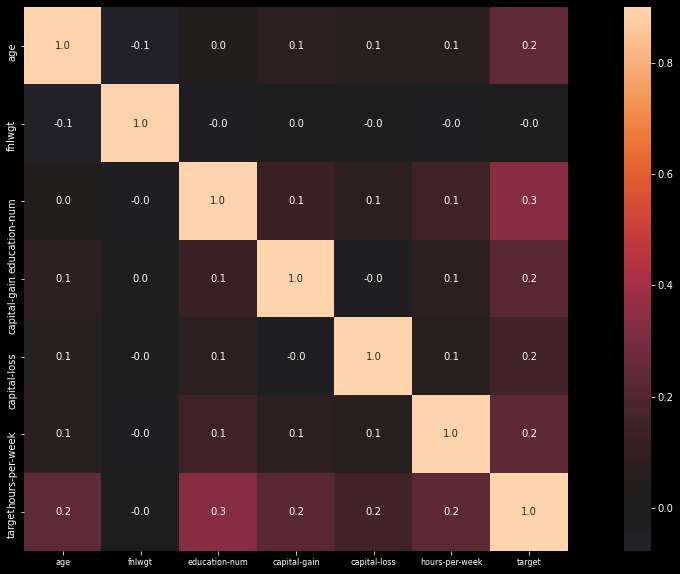

In [68]:
plt.subplots(figsize=(20, 10))
sns.heatmap(df.corr(), vmax=.9, square=True, annot=True, fmt='.1f', center=0)
plt.show()

I will drop <b>FNLWGT</b> beacuse has 0 corelation to target value

In [69]:
df = df.drop(['fnlwgt'], axis=1)

I will drop education, beacuse <b>Education</b> and <b>Education Number</b> are the same

In [70]:
df.drop(['education'], axis = 1, inplace = True)

In [71]:
df.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [82]:
target = 'target'
num_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'education-num']
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
features = df.columns.tolist()
features.remove(target)
X = df[features]
y = df[target]

In [73]:
def other_under_x(column, dataframe = df, percent=0.05, name_for_other="Other"):
    frame = dataframe[column].value_counts().to_frame()
    values =  dataframe[column].value_counts().index.tolist()
    sum_of_count = 0
    for n in range(len(frame.index)): 
        sum_of_count += frame.iloc[n]
    threshold = sum_of_count.iloc[0]*percent
    list_values_to_change= []
    for i in range(len(frame.index)):
        num = frame.iloc[i, 0]
        if(num < threshold):
            list_values_to_change.append(values[i])
    dataframe[column].replace(list_values_to_change, name_for_other, inplace = True)

In [113]:
insignificant_values = ['workclass', 'occupation', 'race', 'native-country']
for value in insignificant_values:
    other_under_x(column=value, dataframe=df, percent=0.04)

In [114]:
target = 'target'
num_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'education-num']
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
features = df.columns.tolist()
features.remove(target)
X = df[features]
y = df[target]

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [123]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
    ('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

In [124]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  DecisionTreeClassifier())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

TypeError: fit_transform() takes 2 positional arguments but 3 were given

In [112]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  RandomForestClassifier())])
param = {'max_depth': [2, 10, 20],
         'n_estimators': [100, 500],
         'max_features': [10 , 20]}
GridSearch(param = param, estimator = clf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: Invalid parameter max_depth for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'education-num']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', RandomForestClassifier())]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [0, 1])])
#---------
# define model
model = LogisticRegression()
# define transform
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [0, 1])])
# define pipeline
pipeline = Pipeline(steps=[('t', transformer), ('m',model)])
# fit the pipeline on the transformed data
pipeline.fit(train_X, train_y)
# make predictions
yhat = pipeline.predict(test_X)